In [23]:
import os

import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import random
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
import eli5

In [24]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')

# train_pred = pd.read_csv('./simple_xgboost_cv.csv', index_col='TransactionID')
# test_pred = pd.read_csv('./simple_xgboost_pred.csv', index_col='TransactionID')
# test_pred['pred'] = (test_pred['pred1'] + test_pred['pred2'] + test_pred['pred3'] )/3
# del test_pred['pred1'],test_pred['pred2'],test_pred['pred3']

# train_f2 = pd.read_csv('../input/f2_train.csv', index_col='TransactionID')
# del train_f2['isFraud']
# test_f2 = pd.read_csv('../input/f2_test.csv', index_col='TransactionID')

sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

CPU times: user 50.6 s, sys: 3.7 s, total: 54.3 s
Wall time: 54.1 s


In [25]:
train_transaction['hour'] = train_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
test_transaction['hour'] = test_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
train_transaction['weekday'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
test_transaction['weekday'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)

In [26]:
train_test = train_transaction.append(test_transaction)
for col in "ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].count()
    train_transaction[col+'_count'] = train_transaction[col].map(col_count)
    test_transaction[col+'_count'] = test_transaction[col].map(col_count)
    s = set(train_transaction[col].tolist())
#     print(col,test_transaction[col].map(lambda x:0 if x in s else 1).sum())


for col in "card1,card2,card5,addr1,addr2".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
    col_count1 = train_test[train_test['C5'] == 0].groupby(col)['C5'].count()
    col_count2 = train_test[train_test['C5'] != 0].groupby(col)['C5'].count()
    train_transaction[col+'_C5count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
    test_transaction[col+'_C5count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
#     col_count1 = train_test[train_test['C14'] == 0].groupby(col)['C14'].count()
#     col_count2 = train_test[train_test['C14'] != 0].groupby(col)['C14'].count()
#     train_transaction[col+'_C14count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
#     test_transaction[col+'_C14count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
# for col in "card1,card2,card3,card5,card6,addr1,addr2,C1,C2".split(","):
#     col_count = train_test.groupby(col)['TransactionDT'].first()
#     train_transaction[col+'_first_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_first_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
#     col_count = train_test.groupby(col)['TransactionDT'].last()
#     train_transaction[col+'_last_dt'] = train_transaction[col].map(col_count) - train_transaction['TransactionDT']
#     test_transaction[col+'_last_dt'] = test_transaction[col].map(col_count) - test_transaction['TransactionDT']
    
#     print(col,len(set(train_transaction[col].tolist())),len(set(test_transaction[col].tolist())),len(set(test_transaction[col].tolist()) - set(train_transaction[col].tolist())))

# card1 13553 13244 3538
# card2 9433 9151 8655
# card3 1679 3117 3021
# card4 5 5 0
# card5 4378 4649 4566
# card6 5 4 0
# addr1 66038 65901 65718
# addr2 65780 65681 65628
# C1 1657 1177 533
# C2 1216 1126 571
# C3 27 34 8
# C4 1260 731 275
# C5 319 356 37
# C6 1328 837 249
# C7 1103 521 235
# C8 1253 445 169
# C9 205 357 158
# C10 1231 459 159
# C11 1476 940 361
# C12 1199 666 334
# C13 1597 5817 4842
# C14 1108 572 45


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [27]:
train_test = train_identity.append(test_identity).fillna(-1)    
for col in "id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo".split(","):
    col_count = train_test.groupby(col)['id_01'].count()
    train_identity[col+'_count'] = train_identity[col].fillna(-1).map(col_count)
    test_identity[col+'_count'] = test_identity[col].fillna(-1).map(col_count)

In [28]:
# print(train_transaction[train_transaction['isFraud'] == 1].card1.value_counts())
# print(train_transaction.card1.value_counts())
# print(train_transaction[train_transaction['card1'] == 4504].isFraud.value_counts())
# print(train_transaction[train_transaction['card1'] == 7919].isFraud.value_counts())
# print(train_transaction[train_transaction['card1'] == 9500].isFraud.value_counts())
# print(train_transaction[train_transaction['card1'] == 15885].isFraud.value_counts())
# print(train_transaction.isFraud.value_counts())

# print(train_transaction[['dist1','dist2','addr1','addr2']].head(10))
# print(train_transaction[train_transaction['isFraud'] == 1].head(10))
# print(train_transaction.hour.value_counts())
# print(train_transaction.isFraud.value_counts())



# print(train_transaction.corr())

print(train_transaction[train_transaction['C5'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C5'] == 1].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['C14'] == 1].isFraud.value_counts())
print(train_transaction.V70.fillna(7).value_counts())
print(train_transaction[train_transaction['V70'] == 0].isFraud.value_counts())
print(train_transaction[train_transaction['V70'].isna()].isFraud.value_counts())

0    353676
1     18759
Name: isFraud, dtype: int64
0    121954
1       929
Name: isFraud, dtype: int64
0    30733
1     5214
Name: isFraud, dtype: int64
0    311589
1      8600
Name: isFraud, dtype: int64
0.0    317801
1.0    184177
7.0     77096
2.0      9739
3.0      1296
4.0       253
5.0       177
6.0         1
Name: V70, dtype: int64
0    303021
1     14780
Name: isFraud, dtype: int64
0    72587
1     4509
Name: isFraud, dtype: int64


In [29]:
# train_identity['has_identity'] = 1
# test_identity['has_identity'] = 1
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
# train['has_identity'] = train['has_identity'].fillna(0)
# test['has_identity'] = test['has_identity'].fillna(0)
# train = train.merge(train_f2, how='left', left_index=True, right_index=True)
# test = test.merge(test_f2, how='left', left_index=True, right_index=True)
train[train['isFraud'] == 1].to_csv('./fraud.csv')
print(train.shape)
print(test.shape)

test['isFraud'] = 0
y_train = train['isFraud'].copy()
y_test = test['isFraud'].copy()
del train_identity, test_identity
# del train_transaction, test_transaction
# del train['card1'],test['card1'],train['card2'],test['card2']
# del train['TransactionDT'],test['TransactionDT']

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.drop('isFraud', axis=1)

# del train, test

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        if f in ['card1','card2','id_01']:
            X_train[f] = X_train[f].fillna(-1)
            X_test[f] = X_test[f].fillna(-1)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

In [30]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

debug = True
if debug:
    split_pos = X_train.shape[0]*4//5
    y_test = y_train.iloc[split_pos:]
    y_train = y_train.iloc[:split_pos]
    X_test = X_train.iloc[split_pos:,:]
    X_train = X_train.iloc[:split_pos,:]

Memory usage of dataframe is 2344.82 MB
Memory usage after optimization is: 713.84 MB
Decreased by 69.6%
Memory usage of dataframe is 2014.72 MB
Memory usage after optimization is: 623.06 MB
Decreased by 69.1%
CPU times: user 3min 3s, sys: 7min 58s, total: 11min 2s
Wall time: 11min


In [31]:
%%time

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
X_test_pred = pd.DataFrame(index = X_test.index)
X_train_pred = pd.DataFrame(index = X_train.index)
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=700,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds+= clf.predict_proba(X_test)[:,1] / folds
    X_test_pred['pred'+str(i)] = clf.predict_proba(X_test)[:,1]
    if debug:    
        print("debug:",roc_auc_score(y_test, clf.predict_proba(X_test)[:,1] / folds))   

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))  

X_train_pred['pred'] = y_oof
X_train_pred['isFraud'] = y_train
X_train_pred['card1'] = X_train['card1']
X_train_pred['card2'] = X_train['card2']
X_train_pred['TransactionAmt'] = X_train['TransactionAmt']
X_train_pred.to_csv('simple_xgboost_cv2.csv')
X_test_pred['card1'] = X_test['card1']
X_test_pred['card2'] = X_test['card2']
X_test_pred['TransactionAmt'] = X_test['TransactionAmt']
X_test_pred.to_csv('simple_xgboost_pred2.csv')

ROC AUC 0.9661782611986149
debug: 0.9263564646412201
ROC AUC 0.9664873088495958
debug: 0.9272125435182221
ROC AUC 0.9680967956774408
debug: 0.9249260589813795
debug: 0.9311505374220808
CPU times: user 2min 17s, sys: 1min 16s, total: 3min 33s
Wall time: 3min 47s


In [32]:
temp = X_train.loc[2987367:2987368]
temp2 = X_train.loc[2987366:2987367]
temp11 = train.loc[2987367:2987368]
temp22 = train.loc[2987366:2987367]
temp3 = temp.copy()
# print(temp.values)
# clf.predict_proba(X_train.loc[2990196:2990197])[:,1]
print(X_train.V70.value_counts())
for i in range(X_train.shape[1]-1,-1,-1):
    
    temp3.iloc[0,i] = temp2.iloc[0,i]
    print(i,X_train.columns[i],temp.iloc[0,i],temp2.iloc[0,i],temp11[X_train.columns[i]].iloc[0],temp22[X_train.columns[i]].iloc[0],clf.predict_proba(temp3)[:,1])
    
# C5 C14 V70

0.0    251774
1.0    144743
2.0      7687
3.0      1021
4.0       186
5.0       130
6.0         1
Name: V70, dtype: int64
514 DeviceInfo_count 378.0 38502.0 378.0 38502.0 [0.9941968  0.02554537]
513 DeviceType_count 159568.0 118173.0 159568.0 118173.0 [0.9943703  0.02554537]
512 id_38_count 168980.0 108982.0 168980.0 108982.0 [0.9943703  0.02554537]
511 id_37_count 215149.0 215149.0 215149.0 215149.0 [0.9943703  0.02554537]
510 id_36_count 267353.0 267353.0 267353.0 267353.0 [0.9943703  0.02554537]
509 id_35_count 149464.0 149464.0 149464.0 149464.0 [0.9943703  0.02554537]
508 id_34_count 132185.0 17377.0 132185.0 17377.0 [0.9943633  0.02554537]
507 id_33_count 8127.0 6556.0 8127.0 6556.0 [0.99410015 0.02554537]
506 id_32_count 104040.0 44077.0 104040.0 44077.0 [0.9941738  0.02554537]
505 id_31_count 926.0 23650.0 926.0 23655.0 [0.99390477 0.02554537]
504 id_30_count 42170.0 711.0 42170.0 711.0 [0.9948913  0.02554537]
503 id_29_count 149264.0 149264.0 149264.0 149264.0 [0.9948913  0.02

389 V337 0.0 0.0 0.0 0.0 [0.99678314 0.02554537]
388 V336 0.0 0.0 0.0 0.0 [0.99678314 0.02554537]
387 V335 0.0 20.0 0.0 20.0 [0.99678314 0.02554537]
386 V334 0.0 0.0 0.0 0.0 [0.99678314 0.02554537]
385 V333 0.0 0.0 0.0 0.0 [0.99678314 0.02554537]
384 V332 0.0 20.0 0.0 20.0 [0.99675995 0.02554537]
383 V331 0.0 0.0 0.0 0.0 [0.99675995 0.02554537]
382 V330 0.0 0.0 0.0 0.0 [0.99675995 0.02554537]
381 V329 0.0 0.0 0.0 0.0 [0.99675995 0.02554537]
380 V328 0.0 0.0 0.0 0.0 [0.99675995 0.02554537]
379 V327 0.0 0.0 0.0 0.0 [0.99675995 0.02554537]
378 V326 0.0 1.0 0.0 1.0 [0.99667114 0.02554537]
377 V325 0.0 0.0 0.0 0.0 [0.99667114 0.02554537]
376 V324 0.0 0.0 0.0 0.0 [0.99667114 0.02554537]
375 V323 0.0 1.0 0.0 1.0 [0.99667114 0.02554537]
374 V322 0.0 0.0 0.0 0.0 [0.99667114 0.02554537]
373 V321 0.0 0.0 0.0 0.0 [0.99667114 0.02554537]
372 V320 0.0 0.0 0.0 0.0 [0.99667114 0.02554537]
371 V319 0.0 0.0 0.0 0.0 [0.99667114 0.02554537]
370 V318 0.0 0.0 0.0 0.0 [0.99667114 0.02554537]
369 V317 0.0 0.0

221 V169 0.0 0.0 0.0 0.0 [0.9868787  0.02554537]
220 V168 3.0 0.0 3.0 0.0 [0.9868787  0.02554537]
219 V167 3.0 0.0 3.0 0.0 [0.9868787  0.02554537]
218 V166 475.0 0.0 475.0 0.0 [0.98738956 0.02554537]
217 V165 250.0 0.0 250.0 0.0 [0.98738956 0.02554537]
216 V164 250.0 0.0 250.0 0.0 [0.9880229  0.02554537]
215 V163 0.0 0.0 0.0 0.0 [0.9880229  0.02554537]
214 V162 0.0 0.0 0.0 0.0 [0.9880229  0.02554537]
213 V161 0.0 0.0 0.0 0.0 [0.9880229  0.02554537]
212 V160 0.0 40.0 0.0 40.0 [0.98744386 0.02554537]
211 V159 0.0 0.0 0.0 0.0 [0.98744386 0.02554537]
210 V158 0.0 0.0 0.0 0.0 [0.98744386 0.02554537]
209 V157 0.0 0.0 0.0 0.0 [0.98744386 0.02554537]
208 V156 0.0 0.0 0.0 0.0 [0.98744386 0.02554537]
207 V155 0.0 0.0 0.0 0.0 [0.98744386 0.02554537]
206 V154 0.0 0.0 0.0 0.0 [0.98744386 0.02554537]
205 V153 0.0 0.0 0.0 0.0 [0.98744386 0.02554537]
204 V152 4.0 1.0 4.0 1.0 [0.98658425 0.02554537]
203 V151 4.0 1.0 4.0 1.0 [0.98658425 0.02554537]
202 V150 4.0 1.0 4.0 1.0 [0.98658425 0.02554537]
201 V1

49 M6 2 2 nan nan [0.98434514 0.02554537]
48 M5 2 2 nan nan [0.98434514 0.02554537]
47 M4 3 3 nan nan [0.98434514 0.02554537]
46 M3 2 2 nan nan [0.98434514 0.02554537]
45 M2 2 2 nan nan [0.98434514 0.02554537]
44 M1 2 2 nan nan [0.98434514 0.02554537]
43 D15 nan 280.0 nan 280.0 [0.9744586  0.02554537]
42 D14 386.0 nan 386.0 nan [0.97459644 0.02554537]
41 D13 nan nan nan nan [0.97459644 0.02554537]
40 D12 nan nan nan nan [0.97459644 0.02554537]
39 D11 nan nan nan nan [0.97459644 0.02554537]
38 D10 nan nan nan nan [0.97459644 0.02554537]
37 D9 0.04166 0.04166 0.04166600108146668 0.04166600108146668 [0.97459644 0.02554537]
36 D8 1.042 17.05 1.041666030883789 17.04166603088379 [0.9740181  0.02554537]
35 D7 nan 16.0 nan 16.0 [0.97431254 0.02554537]
34 D6 nan 55.0 nan 55.0 [0.9620047  0.02554537]
33 D5 nan nan nan nan [0.9620047  0.02554537]
32 D4 nan nan nan nan [0.9620047  0.02554537]
31 D3 nan nan nan nan [0.9620047  0.02554537]
30 D2 nan 17.0 nan 17.0 [0.9639276  0.02554537]
29 D1 0.0 17

In [33]:
from sklearn.feature_extraction import DictVectorizer
# print(eli5.explain_prediction_xgboost(clf,X_test.iloc[0,:], vec = vec))
eli5.show_weights(clf)
# print(res.data)
# eli5.explain_prediction(clf,X_test.iloc[10,:])
# eli5.show_prediction(clf, X_train.iloc[10:11,:],show_feature_values=True)


Weight,Feature
0.1070,V258
0.0309,V257
0.0225,V70
0.0208,V189
0.0201,V244
0.0146,C1_count
0.0133,V91
0.0128,V294
0.0105,C4_count
0.0105,C14


In [34]:
import lightgbm as lgb
# feat_col = [x for x in X_train.columns if x in ['stationID','hour', 'min', 'minandhour','num_neighboor', 'station_time0', 'station_time1',
#        'station_time2', 'station_time3', 'station_pos', 'station_pos2',  'datediff',
#        'station_time_diff_0', 'station_time_diff_1', 'station_time_diff_2',
#        'station_time_diff_3', 'th', 'tl', 'cloud', 'rain1','line0','line0b','line1','line2',
#        'rain2', 'cloud2', 'cloud3', 'sun', 'weekday', 'weekend','type','railway','busstation'] or x.startswith("svd") or x.startswith("w2v") or x.startswith("poi")]
cate = [x for x in X_train.columns if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") ]
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'auc',
          'max_depth': 15,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 500,
          'min_child_weight': 2,
          'data_random_seed': 17}
early_stop = 500
verbose_eval = 30
num_rounds = 600
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds2 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    d_valid = lgb.Dataset(X_vl, label=y_vl,categorical_feature = cate)
    watchlist = [d_valid]
    if debug:
        d_test = lgb.Dataset(X_test, label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    y_pred_train = model.predict(X_vl)
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds2+= model.predict(X_test) / folds
    
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict(X_test) / folds))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5))  




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.946009	valid_1's auc: 0.893011
[60]	valid_0's auc: 0.962022	valid_1's auc: 0.906646
[90]	valid_0's auc: 0.966349	valid_1's auc: 0.911341
[120]	valid_0's auc: 0.968298	valid_1's auc: 0.912098
[150]	valid_0's auc: 0.969551	valid_1's auc: 0.912723
[180]	valid_0's auc: 0.970342	valid_1's auc: 0.913337
[210]	valid_0's auc: 0.971018	valid_1's auc: 0.913994
[240]	valid_0's auc: 0.971368	valid_1's auc: 0.914019
[270]	valid_0's auc: 0.971719	valid_1's auc: 0.914698
[300]	valid_0's auc: 0.971975	valid_1's auc: 0.914449
[330]	valid_0's auc: 0.972071	valid_1's auc: 0.914923
[360]	valid_0's auc: 0.972146	valid_1's auc: 0.915073
[390]	valid_0's auc: 0.972214	valid_1's auc: 0.915203
[420]	valid_0's auc: 0.972195	valid_1's auc: 0.915378
[450]	valid_0's auc: 0.972153	valid_1's auc: 0.915508
[480]	valid_0's auc: 0.972084	valid_1's auc: 0.915411
[510]	valid_0's auc: 0.971956	valid_1's auc: 0.915348
[540]	valid_0's auc: 0.971889	valid_1's auc: 0.9153
[570]	valid_0's auc: 0.971807	val

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.944355	valid_1's auc: 0.894054
[60]	valid_0's auc: 0.960373	valid_1's auc: 0.90683
[90]	valid_0's auc: 0.965481	valid_1's auc: 0.910917
[120]	valid_0's auc: 0.96747	valid_1's auc: 0.91132
[150]	valid_0's auc: 0.968652	valid_1's auc: 0.912397
[180]	valid_0's auc: 0.969504	valid_1's auc: 0.91335
[210]	valid_0's auc: 0.96996	valid_1's auc: 0.91337
[240]	valid_0's auc: 0.970482	valid_1's auc: 0.913939
[270]	valid_0's auc: 0.970859	valid_1's auc: 0.914344
[300]	valid_0's auc: 0.971093	valid_1's auc: 0.914704
[330]	valid_0's auc: 0.971383	valid_1's auc: 0.914579
[360]	valid_0's auc: 0.971646	valid_1's auc: 0.91501
[390]	valid_0's auc: 0.971811	valid_1's auc: 0.915083
[420]	valid_0's auc: 0.971926	valid_1's auc: 0.915667
[450]	valid_0's auc: 0.972045	valid_1's auc: 0.915815
[480]	valid_0's auc: 0.971992	valid_1's auc: 0.915926
[510]	valid_0's auc: 0.972031	valid_1's auc: 0.916177
[540]	valid_0's auc: 0.971986	valid_1's auc: 0.916307
[570]	valid_0's auc: 0.971968	valid_1'

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[30]	valid_0's auc: 0.94962	valid_1's auc: 0.898732
[60]	valid_0's auc: 0.963153	valid_1's auc: 0.90902
[90]	valid_0's auc: 0.96836	valid_1's auc: 0.913747
[120]	valid_0's auc: 0.97058	valid_1's auc: 0.914572
[150]	valid_0's auc: 0.971799	valid_1's auc: 0.914971
[180]	valid_0's auc: 0.972733	valid_1's auc: 0.91607
[210]	valid_0's auc: 0.973058	valid_1's auc: 0.915761
[240]	valid_0's auc: 0.973257	valid_1's auc: 0.916072
[270]	valid_0's auc: 0.97336	valid_1's auc: 0.916355
[300]	valid_0's auc: 0.973599	valid_1's auc: 0.916477
[330]	valid_0's auc: 0.973722	valid_1's auc: 0.916546
[360]	valid_0's auc: 0.973824	valid_1's auc: 0.916384
[390]	valid_0's auc: 0.973897	valid_1's auc: 0.916469
[420]	valid_0's auc: 0.973841	valid_1's auc: 0.916703
[450]	valid_0's auc: 0.973888	valid_1's auc: 0.917225
[480]	valid_0's auc: 0.973845	valid_1's auc: 0.917143
[510]	valid_0's auc: 0.973885	valid_1's auc: 0.917322
[540]	valid_0's auc: 0.973909	valid_1's auc: 0.917603
[570]	valid_0's auc: 0.973939	valid_1

In [35]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5)) 

debug: 0.9311505374220808
debug: 0.9250899125444606
debug: 0.9371159575583067


Index(['TransactionDT', 'card1', 'TransactionAmt', 'card1_count', 'hour',
       'addr1', 'D15', 'weekday', 'addr1_count', 'id_02', 'dist1',
       'card1_C5count', 'D4', 'card2_count', 'addr1_C5count', 'addr1_amtcount',
       'card1_amtcount', 'D10', 'card2', 'card2_C5count', 'D2', 'C13', 'id_20',
       'card2_amtcount', 'D8', 'id_31_count', 'id_20_count', 'id_19',
       'id_19_count', 'D11', 'D5', 'C13_count', 'D1', 'D3', 'DeviceInfo_count',
       'C1', 'id_31', 'C14_count', 'dist2', 'M4_count', 'C2', 'C1_count',
       'V307', 'P_emaildomain', 'card5_count', 'C6_count', 'D9', 'DeviceInfo',
       'C14', 'M5_count', 'C11', 'id_06', 'id_13', 'D14', 'C6',
       'card5_amtcount', 'card5_C5count', 'M6_count', 'C2_count',
       'id_13_count', 'id_05', 'id_06_count', 'id_05_count', 'V313', 'V310',
       'M4', 'id_01', 'C11_count', 'C9_count', 'M6', 'id_01_count', 'V127',
       'D6', 'C9', 'V45', 'id_30_count', 'id_33_count', 'V87', 'D12', 'V308',
       'V315', 'V75', 'V264', 'V53'

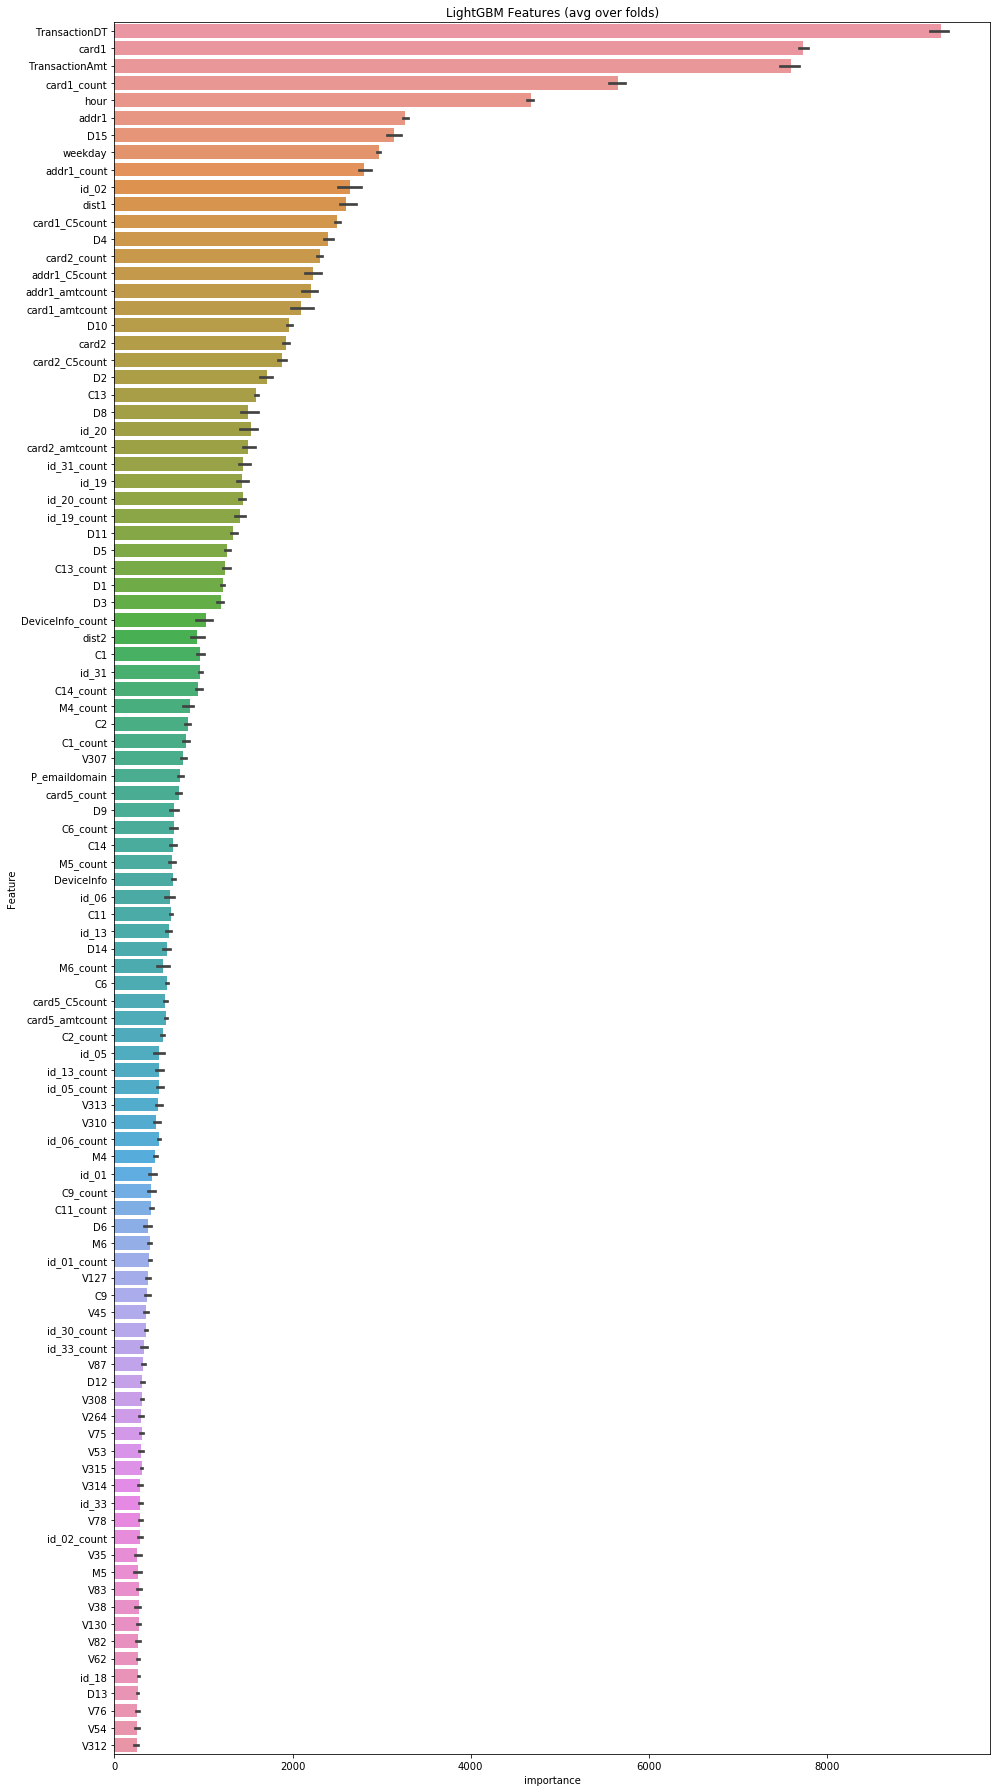

In [36]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
print(cols)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [37]:
import catboost as cb
from catboost import CatBoostClassifier,Pool




cate = [x for x in X_train.columns if (x == 'ProductCD' or x.startswith("card") or x.startswith("addr") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") and not x == "id_11" ]

# cate = []
print(cate)
verbose_eval = 30
num_rounds = 1000

folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds3 = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr, X_vl = X_train.iloc[tr_idx, :].fillna(-1), X_train.iloc[val_idx, :].fillna(-1)
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    model=cb.CatBoostClassifier(iterations=num_rounds,depth=11,min_data_in_leaf = 5,learning_rate=0.05,loss_function='Logloss',eval_metric='Logloss'
                                ,task_type = "GPU",devices = ["1"])
    if debug:
        model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_test.fillna(-1), y_test),verbose_eval = 30)
    else:
        model.fit(X_tr,y_tr,cat_features=cate,eval_set=(X_vl, y_vl),verbose_eval = 30)
        
    y_pred_train = model.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print('ROC AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    
    y_preds3+= model.predict_proba(X_test.fillna(-1))[:,1] / folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict_proba(X_test.fillna(-1))[:,1] / folds))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33))

['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']
0:	learn: 0.6040703	test: 0.6051662	best: 0.6051662 (0)	total: 184ms	remaining: 3m 3s
30:	learn: 0.0871997	test: 0.1026417	best: 0.1026417 (30)	total: 4.83s	remaining: 2m 30s
60:	learn: 0.0677229	test: 0.0903545	best: 0.0903545 (60)	total: 9.69s	remaining: 2m 29s
90:	learn: 0.0620350	test: 0.0877983	best: 0.0877983 (90)	total: 14.4s	remaining: 2m 24s
120:	learn: 0.0590958	test: 0.0864172	best: 0.0864172 (120)	total: 19.1s	remaining: 2m 19s
150:	learn: 0.0573285	test: 0.0858646	best: 0.0858636 (149)	total: 23.7s	remaining: 2m 13s
180:	learn: 0.0555263	test: 0.0852724	best: 0.0852724 (180)	total: 28.4s	remaining: 2m 8s
210:	learn: 0.0543987	test: 0.0848852	best: 0.0848852 (210)	total: 32.9s	remaining: 2m 3s
240:	learn: 0.0533088	test: 0.0845255	best: 0.0845255 (240)	total: 37.5s	remaining: 1m 58s
270:	learn: 0.0523241	test: 0.0841634	best: 0.

480:	learn: 0.0474764	test: 0.0832167	best: 0.0832167 (480)	total: 1m 15s	remaining: 1m 21s
510:	learn: 0.0469831	test: 0.0831407	best: 0.0831274 (508)	total: 1m 20s	remaining: 1m 17s
540:	learn: 0.0462252	test: 0.0830514	best: 0.0830406 (538)	total: 1m 25s	remaining: 1m 12s
570:	learn: 0.0454425	test: 0.0828721	best: 0.0828721 (570)	total: 1m 30s	remaining: 1m 7s
600:	learn: 0.0448384	test: 0.0827348	best: 0.0827331 (598)	total: 1m 34s	remaining: 1m 2s
630:	learn: 0.0443188	test: 0.0826970	best: 0.0826837 (626)	total: 1m 39s	remaining: 58.2s
660:	learn: 0.0438530	test: 0.0826604	best: 0.0826509 (658)	total: 1m 44s	remaining: 53.5s
690:	learn: 0.0432695	test: 0.0825031	best: 0.0825031 (690)	total: 1m 49s	remaining: 48.8s
720:	learn: 0.0428667	test: 0.0824530	best: 0.0824530 (720)	total: 1m 53s	remaining: 44s
750:	learn: 0.0423752	test: 0.0824509	best: 0.0824376 (737)	total: 1m 58s	remaining: 39.3s
780:	learn: 0.0416482	test: 0.0823997	best: 0.0823755 (773)	total: 2m 3s	remaining: 34.6s

In [38]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))
    print("debug:",roc_auc_score(y_test, y_preds2))
    print("debug:",roc_auc_score(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33))

debug: 0.9311505374220808
debug: 0.9250899125444606
debug: 0.9194201201214782
debug: 0.9343207916608784
debug: 0.9383278788550184


In [39]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))
    print("debug:",roc_auc_score(y_test, y_preds2))
    print("debug:",roc_auc_score(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33))

debug: 0.9311505374220808
debug: 0.9250899125444606
debug: 0.9194201201214782
debug: 0.9343207916608784
debug: 0.9383278788550184


In [40]:

sample_submission['isFraud'] = (y_preds + y_preds2 + y_preds3*0.5)*0.33
sample_submission.to_csv('simple_ensemble5.csv')


ValueError: Length of values does not match length of index